In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import tensorflow as tf
from PIL import Image
import pathlib

In [0]:
!unzip my_fruits_dataset.zip

In [0]:
!pip install split-folders

In [0]:
import split_folders

In [0]:
split_folders.ratio('/content/my_fruits_dataset', 'dataset_splitted', ratio=(.8, .1, .1))

Copying files: 299 files [00:00, 5989.49 files/s]


In [0]:
image_shape = (240,320,3)

In [0]:
data_dir = pathlib.Path('/content/dataset_splitted/train')
data_dir_test = pathlib.Path('/content/dataset_splitted/test')
data_dir_val = pathlib.Path('/content/dataset_splitted/val')

In [0]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

239

In [0]:
len(list(data_dir_test.glob('*/*.jpg')))

31

In [0]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*')])
CLASS_NAMES

array(['Lemon', 'Banana', 'Pear', 'Walnut', 'Kiwi', 'Apple'], dtype='<U6')

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
train_image_gen = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.10,
                               height_shift_range=0.10,
                               rescale=1/255,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='nearest'
                              )

In [0]:
test_val_image_gen = ImageDataGenerator(rescale=1/255)

In [0]:
BATCH_SIZE = 32
IMG_HEIGHT = 240
IMG_WIDTH = 320
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [0]:
train_data_gen = train_image_gen.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 239 images belonging to 6 classes.


In [0]:
val_data_gen = test_val_image_gen.flow_from_directory(directory=str(data_dir_val),
                                                    #  batch_size=None,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 29 images belonging to 6 classes.


In [0]:
test_data_gen = test_val_image_gen.flow_from_directory(directory=str(data_dir_test),
                                                    #  batch_size=None,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 31 images belonging to 6 classes.


In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

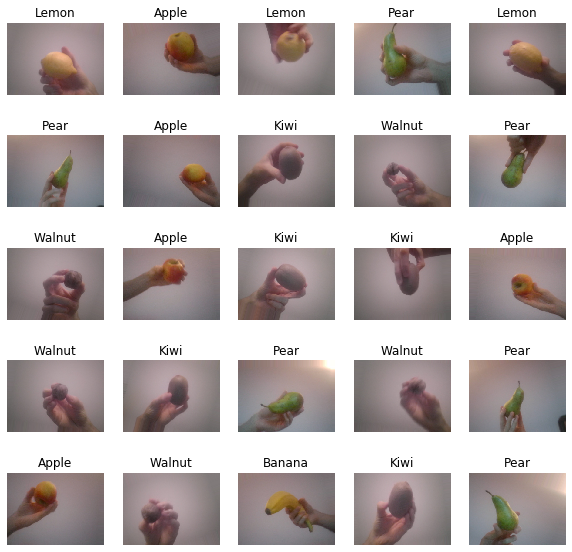

In [0]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [0]:
base_model = tf.keras.applications.VGG19(input_shape=image_shape,
                                               include_top=False, pooling='max')

80142336/80134624 [==============================] - 1s 0us/step


In [0]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 512)


In [0]:
base_model.trainable = False

In [0]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 320, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 240, 320, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 240, 320, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 120, 160, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 120, 160, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 120, 160, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 60, 80, 128)       0     

In [0]:
model = tf.keras.Sequential([
                             base_model,
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(256, activation='relu'),
                             tf.keras.layers.Dropout(0.1),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(6, activation='softmax')
])

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 512)               20024384  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 20,172,550
Trainable params: 148,166
Non-trainable params: 20,024,384
______________________________________

In [0]:
len(model.trainable_variables)

6

In [0]:
initial_epochs = 200
steps_per_epoch = round(32)
validation_steps=1

loss0,accuracy0 = model.evaluate(test_data_gen, steps = validation_steps)

  ...
    to  
  ['...']
1/1 [==============================] - 4s 4s/step - loss: 1.9058 - accuracy: 0.0968


In [0]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.91
initial accuracy: 0.10


In [0]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=15, restore_best_weights=True)

In [0]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('fruit_recognition_vgg19_mydataset_240_320.h5', monitor='val_loss', save_best_only=True, verbose=1)

In [0]:
history = model.fit(train_data_gen,
                    epochs=initial_epochs,
                    validation_data=val_data_gen,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_steps=1,
                    callbacks=[checkpoint])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8.0 steps, validate for 1 steps
Epoch 1/200
7/8 [=========================>....] - ETA: 0s - loss: 1.7257 - accuracy: 0.2271
Epoch 00001: val_loss improved from inf to 1.57349, saving model to fruit_recognition_vgg19_mydataset_240_320.h5
8/8 [==============================] - 10s 1s/step - loss: 1.7069 - accuracy: 0.2427 - val_loss: 1.5735 - val_accuracy: 0.2759
Epoch 2/200
7/8 [=========================>....] - ETA: 0s - loss: 1.5387 - accuracy: 0.3913
Epoch 00002: val_loss improved from 1.57349 to 1.35707, saving model to fruit_recognition_vgg19_mydataset_240_320.h5
8/8 [==============================] - 6s 746ms/step - loss: 1.5270 - accuracy: 0.4017 - val_loss: 1.3571 - val_accuracy: 0.5862
Epoch 3/200
7/8 [=========================>....] - ETA: 0s - loss: 1.3612 - accuracy: 0.4976
Epoch 00003: val_loss improved from 1.35707 to 1.21655, saving model to fruit_recognition_vgg19_mydataset_240_320.h5
8/8 [=====================

In [0]:
import pandas as pd

In [0]:
metrics = pd.DataFrame(model.history.history)

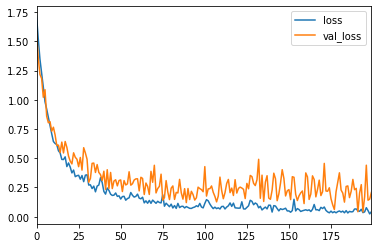

In [0]:
metrics[['loss', 'val_loss']].plot()

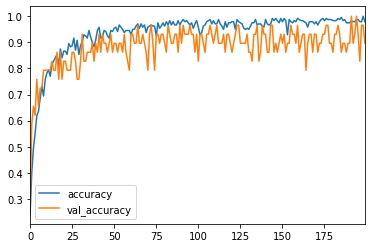

In [0]:
metrics[['accuracy', 'val_accuracy']].plot()

In [0]:
model.evaluate(test_data_gen, steps=1)

  ...
    to  
  ['...']
1/1 [==============================] - 1s 850ms/step - loss: 0.2065 - accuracy: 0.9355


[0.2064996212720871, 0.9354839]

In [0]:
model.metrics_names

['loss', 'accuracy']

In [0]:
pred_probabilities = model.predict(test_data_gen)

In [0]:
pred_probabilities

array([[2.06508394e-05, 5.84917143e-03, 9.94032085e-01, 1.32976970e-06,
        1.57746081e-06, 9.51777474e-05],
       [4.48248466e-06, 9.60232913e-01, 3.97456922e-02, 1.65150366e-10,
        1.61836091e-08, 1.69608375e-05],
       [4.11720574e-03, 1.20537262e-03, 8.64245057e-01, 2.04083084e-09,
        2.15104174e-05, 1.30410939e-01],
       [3.01700318e-03, 2.19319418e-07, 1.19686399e-06, 2.26870319e-03,
        9.94710088e-01, 2.81558414e-06],
       [8.67456911e-05, 1.15443056e-03, 2.11641744e-08, 6.15600073e-13,
        1.06282316e-10, 9.98758793e-01],
       [9.96592820e-01, 1.77139009e-03, 9.55391806e-06, 5.68422465e-08,
        1.62205321e-03, 4.15936984e-06],
       [3.05452568e-06, 9.99996781e-01, 1.23224044e-08, 2.64969720e-16,
        5.85598803e-14, 1.67427586e-07],
       [2.05988006e-04, 1.29398713e-05, 1.09201142e-06, 8.14844286e-12,
        1.86265066e-08, 9.99779999e-01],
       [1.12865781e-02, 1.11026184e-05, 1.26391365e-06, 9.88224626e-01,
        4.25795210e-04, 

In [0]:
test_data_gen.classes

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4,
       4, 4, 4, 4, 5, 5, 5, 5, 5], dtype=int32)

In [0]:
from sklearn.metrics import classification_report,confusion_matrix

In [0]:
predictions = model.predict_classes(test_data_gen, batch_size=None)

In [0]:
classification_report(test_data_gen.classes,predictions)

'              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00         5\n           1       0.33      0.33      0.33         6\n           2       0.20      0.20      0.20         5\n           3       0.33      0.40      0.36         5\n           4       0.25      0.20      0.22         5\n           5       0.00      0.00      0.00         5\n\n    accuracy                           0.19        31\n   macro avg       0.19      0.19      0.19        31\nweighted avg       0.19      0.19      0.19        31\n'